<a href="https://colab.research.google.com/github/moeinset/PyTorch_colorectal_cancer_01/blob/main/Transfer_learning/EfficientNet_B0_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import needed frameworks and libraries
import torch
import torchvision
#We need torch 1.12+ and torchvision 0.13+
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [2]:
#define device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the needed directory, download it from GitHub if it doesn't work
try:
    from mymodules import data_setup, engine, get_data, utils
except:
    # Get the  scripts
    print("[INFO] Couldn't find Modular scripts... downloading them from GitHub.")
    !git clone https://github.com/moeinset/modules
    !mv  modules/mymodules .
    !rm -rf modules
    from mymodules import data_setup, engine, get_data, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find Modular scripts... downloading them from GitHub.
Cloning into 'modules'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [5]:
image_path = get_data.download_data(source="https://cdn-104.anonfiles.com/8ep9p1F8y5/3556c1a1-1668081950/tumor_stroma_lympho.zip",
                           destination="tumor_stroma_lympho")
image_path

[INFO] Did not find data/tumor_stroma_lympho directory, creating one...
[INFO] Downloading tumor_stroma_lympho.zip from https://cdn-104.anonfiles.com/8ep9p1F8y5/3556c1a1-1668081950/tumor_stroma_lympho.zip...
[INFO] Unzipping tumor_stroma_lympho.zip data...


PosixPath('data/tumor_stroma_lympho')

In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()


In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               test_transform=auto_transforms,
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f22ac2be6d0>,
 ['01_TUMOR', '02_STROMA', '04_LYMPHO'])

In [9]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [13]:


# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
import timeit

In [16]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=40,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6256 | train_acc: 0.8144 | test_loss: 0.3290 | test_acc: 0.9360
Epoch: 2 | train_loss: 0.3130 | train_acc: 0.9303 | test_loss: 0.2301 | test_acc: 0.9449
Epoch: 3 | train_loss: 0.2233 | train_acc: 0.9547 | test_loss: 0.1893 | test_acc: 0.9485
Epoch: 4 | train_loss: 0.2138 | train_acc: 0.9413 | test_loss: 0.1671 | test_acc: 0.9557
Epoch: 5 | train_loss: 0.1782 | train_acc: 0.9519 | test_loss: 0.1500 | test_acc: 0.9609
Epoch: 6 | train_loss: 0.1681 | train_acc: 0.9512 | test_loss: 0.1411 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.1593 | train_acc: 0.9581 | test_loss: 0.1372 | test_acc: 0.9609
Epoch: 8 | train_loss: 0.1454 | train_acc: 0.9601 | test_loss: 0.1271 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.1454 | train_acc: 0.9594 | test_loss: 0.1253 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.1535 | train_acc: 0.9526 | test_loss: 0.1226 | test_acc: 0.9688
Epoch: 11 | train_loss: 0.1321 | train_acc: 0.9606 | test_loss: 0.1182 | test_acc: 0.9688
Epoch: 12 | train_l

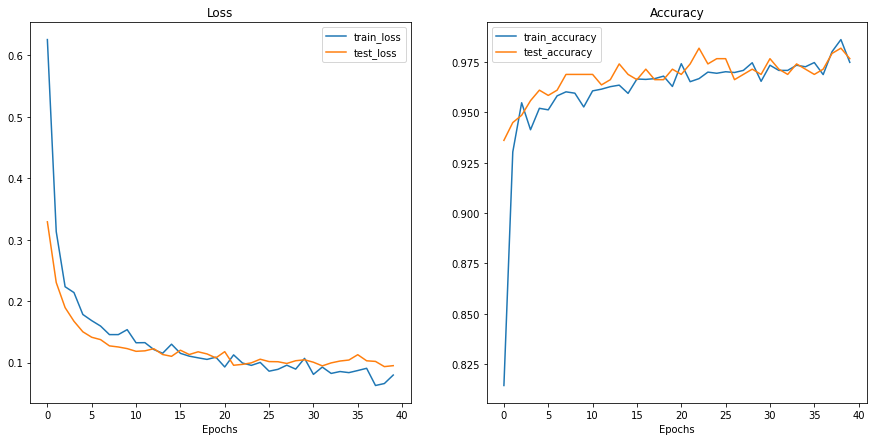

In [17]:
utils.plot_loss_curves(results)